<title>ITI104 Assignment</title>

Name: Liew Chooi Chin <br>
Student ID: 23A056D

# Written Question

Introduction to ensemble methods in general

Details on how Voting and Stacking ensemble methods work

Advantages and benefits of Voting vs Stacking methods, and ensemble methods over single classifier/regressor

Any other facts and figures about Voting, Stacking or other ensemble methods that you find interesting and worth sharing

References


## Ensemble methods in general

Ensemble methods make use of the simple notion that more heads are better than one. When we train using one estimator, the result may not be good enough. But, when we use a few or many individual estimators, together all these estimators will make a powerful estimator. This concept is illustrated below with the all time favourite iris data set and decision trees.

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Load the iris datasets
iris = load_iris()

# To set the random state so that we get a consistent
# result for every run of the program.
RND_NUM = 0

# This is a simple demonstration. Thus, the whole
# dataset is put into cross_val_score to get the
# cross validation score.

# Instantiate a DecisionTreeClassifier
one_tree = DecisionTreeClassifier(
    max_depth=1,
    max_features=1,
    splitter='best',
    random_state=RND_NUM
)

# Obtain the cross validation score
one_tree_score = cross_val_score(
    one_tree, iris.data, iris.target,
    scoring='matthews_corrcoef', cv=10)
one_tree_mean = np.mean(one_tree_score)

# Instantiate a random forest
forest_50 = RandomForestClassifier(
    n_estimators=50,
    max_depth=1,
    max_features=1,
    random_state=RND_NUM
)

# Get the cross validation score
forest_50_score = cross_val_score(
    forest_50, iris.data, iris.target,
    scoring='matthews_corrcoef', cv=10
)
forest_50_mean = np.mean(forest_50_score)

# Instantiate a random forest
forest_100 = RandomForestClassifier(
    n_estimators=100,
    max_depth=1,
    max_features=1,
    random_state=RND_NUM
)

# Get the cross validation score
forest_100_score = cross_val_score(
    forest_100, iris.data, iris.target,
    scoring='matthews_corrcoef', cv=10
)
forest_100_mean = np.mean(forest_100_score)

# Print the score of the one tree classifier
# against the random forest
print("Both decision trees have max_depth=1 and max_features=1.")
print(f"MCC of one tree is {one_tree_mean}.")
print(f"MCC of 100 trees of forest is {forest_50_mean}.")
print(f"MCC of 500 trees of forest is {forest_100_mean}.")

Both decision trees have max_depth=1 and max_features=1.
MCC of one tree is 0.40671833954496905.
MCC of 100 trees of forest is 0.7237401272795637.
MCC of 500 trees of forest is 0.8563395440748758.


We will show the concept of weak learner combined to become a more powerful estimator through the use a one decision tree and a forest of trees. Here, we set the decision trees to a severe set of hyperparameters: `max_depth=1` and `max_features=1`. `Max_depth` of 1 means that the tree can only split once, and `max_features` is the number of features to consider when looking for the best split. Both trees are set to the same unfavourable conditions.

In the one tree model, the MCC score is about 0.4067 while the forest of 50 similar trees give a score of about 0.7237. When we increase the number to 100 trees the MCC improves to 0.8563.

With one decision tree, the tree can make many errors and predictions are unsatisfactory. But when we have 100 such weak learners, we make them into a strong coalition that give a much higher MCC score.  


There three main types of ensemble methods:
- Bagging (bootstrap aggregating of samples with or without replacement)
- Boosting (gradient boosting concept)
- Stacking (including stacking and voting)

Here, we will focus on ensembles using the stacking and voting methods.

## Voting methods

### Hard voting

The concept of voting is simple. We have an aggregate of base models. Each of the models give a prediction. Then the predictions are aggregated. The class that *wins* is the class that has the majority of votes. This method makes use of the actual predictions made by each of the base models. In classification problem, the predicted labels from the base models are counted. The class with the highest *vote count* will be nominated as the most likely class. This is hard voting: one vote, one count.

#### Examples of hard voting in action

For example we have three classifiers and two classes:

|Base models | Classes |
|--- | --- |
|Model_a | 1 |
|Model_b | 0 |
|Model_c | 1 |

Thus, the count for class 0 is 1, and the count for class 1 is 2. So, the hard voting method will make class 1 the final prediction.

#### Odd number of base models

It is interesting to note that majority votes is easy to decide when there are odd number of base models. The cut-off votes for majority is `ceiling(number_of_base_models / 2)`. For example, in the example above, we have three base models and cut-off is `ceiling(3/2)=2`.

#### Even number of base models

So, what happen when we have even number of base models and there are ties in the votes? For example, we have four base models and each class gets two votes.

|Base models | Classes |
|--- | --- |
|Model_a | 1 |
|Model_b | 0 |
|Model_c | 1 |
|Model_d | 0 |

According to sklearn "User Guide" (1.11. Ensemble methods), the case of a tie is clearly documented[^1]. It says that when a tie occurs during hard voting classification, the labels will go in ascending sort order. In the example above, the ascending sort order of the class labels is [0, 1]. So, the class labels will be awarded to 0 in the final prediction.

[^1]: However, this is not documented in the individual `StackingClassifier()` API guide.

The hard voting code below illustrate a manual counting of votes and demonstrate that the counting is consistent with the actual working of the 'VotingClassifier' in sklearn.

### Soft voting

In soft voting, the concept takes into account the voice (value) of each individual base models. Thus, classes with lower number of votes but with high probability will win the race in soft averaging. This is a case where many weak models predict a class with very low probability (thus, high vote count), but there is an odd one out who predict another class with high probability. Then, by using soft voting, this odd one out model will make its voice (probability) heard; whereas in hard voting, this odd one out will lose in the majority vote. This is illustrated in the example below.

| Class  | 0 | 1 | 2 | Prediction |
| --- | --- | --- | --- | --- |
| Model_a | 0.2 | 0.1 | 0.1 | 0 |
| Model_b | 0.3 | 0.1 | 0.2 | 0 |
| Model_c | 0.2 | 0.1 | 0.1 | 0 |
| Model_d | 0.01 | 0.01 | 0.99 | 2 |
| Soft voting | 0.1775 | 0.0775 | 0.6475 | 2 (highest) |
| Hard voting | - | - | - | 0 (3 out of 4) |

By soft average, the highest average of probability belongs to class 2. However, in hard voting, class 0 will have 3 out 4 votes and will win. The advantage of using soft voting is that a class with high prediction probability is likely to win in its prediction.

Soft voting makes use of average of prediction probability, thus, the base estimators must implement `predict_proba()` for use with soft voting.

Soft voting (averaging method) is suitable for classification as well as for regression problem. In sklearn, the regression voting is called `VotingRegressor'. It averages the predictions from the base models to form the final predictions.

The soft voting code below illustrate a manual averaging out prediction probability of each base models using `np.mean()`. Then the manually computed mean is compared to the probability of the `VotingClassifier`. The mean of the two are indeed the same.

### Illustration of voting classifier using a simple dataset from `make_classification`

In this dataset, a small number of points with label [0, 1] are plotted.

Three simple base estimators are used to illustrated the methods of hard and soft voting.
- Hard voting: The votes are counted manually and then shown to be the same as the prediction from the hard voting classifier.
- Soft voting: The prediction probability (`predict_proba()`) of the base estimators are manually computed with `np.mean()`. Then the manually computed average of compared to the probability from soft voting. Then they are shown to be the same with `np.array_equal()`.


Classes in y and their counts: 
[25 25]


VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('knn_a',
                              KNeighborsClassifier(algorithm='brute',
                                                   n_neighbors=1)),
                             ('knn_b',
                              KNeighborsClassifier(algorithm='brute',
                                                   n_neighbors=1))])

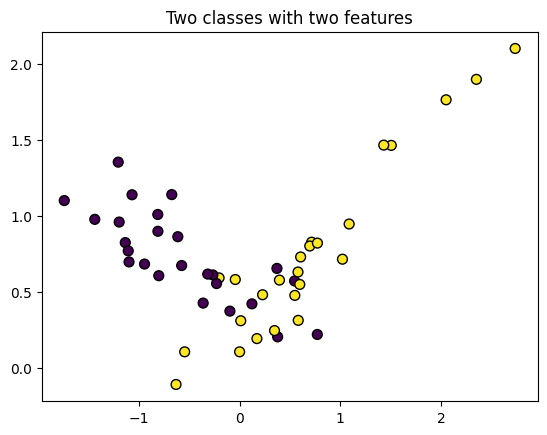

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

RND_NUM = 2

# We use the make_classification to generate two classes.
# One informative feature, one cluster per class.
fig, ax = plt.subplots(nrows=1, ncols=1)
X, y = make_classification(
    n_samples=50, n_classes=2,
    n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1,
    flip_y=0.03, class_sep=0.8,
    random_state=RND_NUM
)
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=50, edgecolor="k")
ax.set_title("Two classes with two features")

# What are the classes we have in y?
print(f"Classes in y and their counts: \n{np.bincount(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.6,
    random_state=RND_NUM,
    shuffle=True
)

# Use base models with different hyperparameters
# The kNN is set to 1 and 10 neighbors. So the outcome can be
# quite interesting.
nb = GaussianNB()
knn_a = KNeighborsClassifier(n_neighbors=1, algorithm='brute')
knn_b = KNeighborsClassifier(n_neighbors=10, algorithm='kd_tree')
base_models = [('nb', nb), ('knn_a', knn_a), ('knn_b', knn_a)]

# Instantiate the hard and soft votinb
soft = VotingClassifier(base_models, voting='soft')
hard = VotingClassifier(base_models, voting='hard')
soft.fit(X_train, y_train)
hard.fit(X_train, y_train)



### Hard voting

Manual count of votes. The majority class will *win*.

In [ ]:
# Get the number of votes in hard voting
hard_pred = hard.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=hard_pred)
print(f"Confusion matrix of hard voting: \n{cm}")

# Count the number of classes in each of the predictor.
# Get the prediction of the base models in
# the hard voting classifier
nb_pred = hard.named_estimators_['nb'].predict(X_test)
#class_count = np.bincount(nb_pred)
#print(f"NB of the hard voting: {class_count}")
print(f"NB prediction:  {nb_pred}")

knn_a_pred = hard.named_estimators_['knn_a'].predict(X_test)
#class_count = np.bincount(knn_a_pred)
#print(f"KNN of the hard voting: {class_count}")
print(f"KNN prediction: {knn_a_pred}")

knn_b_pred = hard.named_estimators_['knn_b'].predict(X_test)
#class_count = np.bincount(knn_b_pred)
#print(f"KNN of the hard voting: {class_count}")
print(f"KNN prediction: {knn_b_pred}")

# Manually taking the vote count from the prediction
# of the base models.
manual_count = []
prediction_sum = np.sum((nb_pred, knn_a_pred, knn_b_pred), axis=0)

# For odd number of base models:
# The majority is ceiling(number_of_base_models/2)
# So, in this example majority is ceiling(3/2)=2
for i in prediction_sum:
    if i >= 2:
        manual_count.append(1)
    else:
        manual_count.append(0)
print(f"Manually counting the prediction vote: \n{manual_count}")

# Compare the manual counting of vote and the prediction of the
# hard voting classifier
result = np.array_equal(manual_count, hard_pred)
print("Result of the manual counting of vote and the prediction \n"
      f"of hard voting is the same: {result}")

Confusion matrix of hard voting: 
[[8 3]
 [2 7]]
NB prediction:  [0 1 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1]
KNN prediction: [0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1]
KNN prediction: [0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1]
Manually counting the prediction vote: 
[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]
Result of the manual counting of vote and the prediction 
of hard voting is the same: True


The above manual counting of votes shows how the hard voting works.

### Soft voting

Average of each base models are manually computed. They are the same as the probability of the soft voting predictions.

In [ ]:
# Get the number of votes in soft voting,
# then use the y_pred as a mask to get the average of
# each class
y_pred = soft.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Get the predict_proba() of the base models of the
# soft voting classifiers
nb_proba = soft.named_estimators_['nb'].predict_proba(X_test)
knn_a_proba = soft.named_estimators_['knn_a'].predict_proba(X_test)
knn_b_proba = soft.named_estimators_['knn_a'].predict_proba(X_test)

# Get the average of the predict_proba of the base
# estimators
base_avg = np.mean((nb_proba, knn_a_proba, knn_b_proba), axis=0)

# Compare the manually computed average to the predict_proba()
# the soft voting classifier
soft_proba = soft.predict_proba(X_test)

# Compare if the manually computed average and the predict_proba()
result = np.array_equal(base_avg, soft_proba)

# Compare which probability is higher, than we will choose the class
class_0 = 0
class_1 = 0
for item in base_avg:
    if item[0] > item[1]:
        class_0 += 1
    else:
        class_1 += 1
print("From the computed average (also the same as predict_proba()) \n"
      f"Count of predicted class 0 is: {class_0}\n"
      f"Count of predicted class 1 is: {class_1}")
print("From the computed average, the number of predicted class 0 and 1 is \n"
      "the same as the number of predicted class of the soft voting classifier.\n"
      f"This is shown in the predicted total of the confusion matrix: \n{cm} \n"
      f"Predicted [0, 1]: {np.sum(cm, axis=0)} \n")

From the computed average (also the same as predict_proba()) 
Count of predicted class 0 is: 10
Count of predicted class 1 is: 10
From the computed average, the number of predicted class 0 and 1 is 
the same as the number of predicted class of the soft voting classifier.
This is shown in the predicted total of the confusion matrix: 
[[8 3]
 [2 7]] 
Predicted [0, 1]: [10 10] 



The above manually computed average shows how soft voting works.

### Decision boundary of soft and hard voting

The decision boundary display of the hard and soft classifiers.

Text(0.5, 1.0, 'Soft voting')

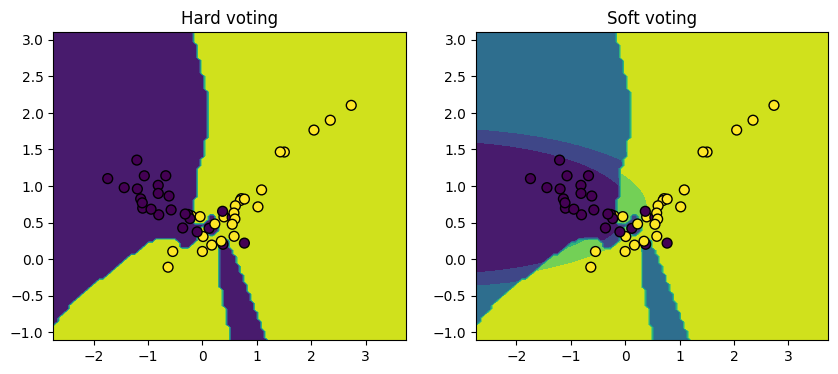

In [ ]:
# Decision boundary by hard and soft voting

from sklearn.inspection import DecisionBoundaryDisplay
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

disp1 = DecisionBoundaryDisplay.from_estimator(
    hard, X, ax=ax[0])
disp1.ax_.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor="k")
disp1.ax_.set_title("Hard voting")


disp2 = DecisionBoundaryDisplay.from_estimator(
    soft, X, ax=ax[1])
disp2.ax_.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor="k")
disp2.ax_.set_title("Soft voting")

## Stacking methods

The concepts of voting methods are simple enough for us to demonstrate its workings. However, instead of just aggregating the majority counts or average, is there other way of predicting using an army of base models? It turns out that there is.

The idea is strikingly obvious. Well, since we are using a few base models to do a few predictions, then why not we also use a model to predict to make predictions from the predictions the base models? This is exactly the idea of stacking methods.

In stacking methods, we use a few or many base models. Then, the predictions from the base models will be blended together by a *final estimator*. The final estimator, well as its name suggests, has the final say on the prediction.

Stacking methods can be used for classification and regression problems.

### How it works

According to the documentation in sklearn, the implementation of stacking methods is as followed:
- First, the training data is fitted to the base models.
- The outputs of the base models are specified by the parameter `stack_method`. The outputs can be any of the `predict_proba()`, `decision_function()` or `predict()`.
- Then, the outputs or predictions from each of the base models are organized together to be fed as input to the final estimator.
- The final estimator is trained by `cross_val_predict()` internally.

### Pros and cons of using stacking classifiers

In order to use stacking ensemble method, the base models need to be trained first. Then the predictions of the base models are input to the final estimator. Therefore, it is a computationally expensive operation.

As we can see, stacking method is a sequential method. The final estimator can get to work only when it has the outputs from all the base estimators.  Also, the time it takes for the final estimator to get to work is as long as the time it takes for the most time consuming base models to complete.

However, there are good points about stacking ensemble methods. The final estimator are trained on the outputs or predictions from the base models. Intuitively, the predictions of the final estimator is only as good as the the best predictions from the base models. However, in practice, this is not the case. The final estimator can often make use of the combined strength of the base models and make a better prediction. Therefore even when the base models are weak in their predictions, the combined predictions fed to the final estimators can be used to make good predictions. So, this come back to the central idea of ensemble learning: many weak learners make a powerful estimator.

### Boosting stacking methods

With the original flavor of stacking, only the outputs or predictions of the base models is used. Well, in order to have the best predictions, why not let the final estimator also take a peek into the original data? Well, sklearn let us do just that.

In stacking methods, there is a parameter call `passthrough`. It is a boolean and default to `False`.
- When `False`, we have the original flavor of stacking methods. That is, only the predictions of estimators will be used as training data for final_estimator.
- When `True`, the final_estimator is trained on the predictions as well as the original training data.

## Stacking regressor in action

Let's take a look at a StackingRegressor at work. Here, we use a simple linear regression problem from `make_regression()`.

Three base models are used, namely `LinearRegression`, `Ridge` and `Lasso`. Both `Ridge` and `Lasso` are set to a severe condition of `max_iter=3` and `alpha=20`. Thus, they are expected to perform badly in the regression problem. And since `LinearRegression` is not bound by any parameter, it is expected to perform well.

Coefficients are 
training 29.972987242456284 
test 44.18331744229961


StackingRegressor(estimators=[('ln', LinearRegression()),
                              ('ridge',
                               Ridge(alpha=20, max_iter=3, random_state=10)),
                              ('lasso',
                               Lasso(alpha=20, max_iter=3, random_state=10))])

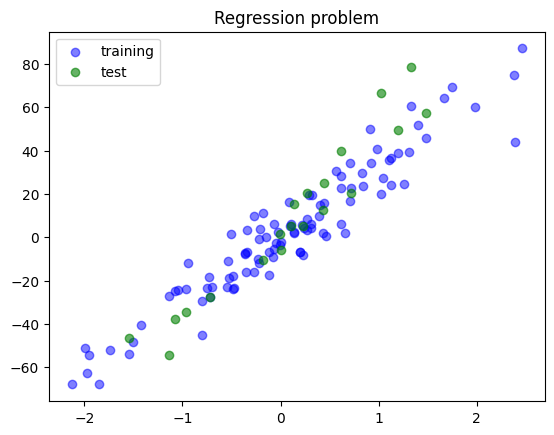

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.datasets import make_regression

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor

# Set the random state
RND_NUM = 10

# Make a simple regression line
X_train, y_train, coef_train = make_regression(
    n_samples=100,
    n_features=1,
    n_informative=1,
    noise=10,
    coef=True,
    random_state=RND_NUM,
)

X_test, y_test, coef_test = make_regression(
    n_samples=20,
    n_features=1,
    n_informative=1,
    noise=10,
    coef=True,
    random_state=RND_NUM
)

print(f"Coefficients are \n"
      f"training {coef_train} \n"
      f"test {coef_test}")

# Plot the regression line
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(X_train, y_train, color='b', alpha=0.5, label='training')
ax.scatter(X_test, y_test, color='g', alpha=0.6, label='test')
ax.legend(loc='best')
ax.set_title("Regression problem")

# Instantiate linear regressors to some
# unfavorable conditions.
MAX_ITER = 3
ALPHA = 20

ln = LinearRegression()

rid = Ridge(
    alpha=ALPHA,
    max_iter=MAX_ITER,
    random_state=RND_NUM
)

las = Lasso(
    alpha=ALPHA,
    max_iter=MAX_ITER,
    random_state=RND_NUM
)

base_models = [
    ('ln', ln),
    ('ridge', rid),
    ('lasso', las)
]

# default final estimator = RidgeCV
# passthrough=False
# default cv=5
st_reg = StackingRegressor(base_models, passthrough=False)

st_reg.fit(X_train, y_train)

In [ ]:
# Use the default score of the regressor:
# coefficient of determination
print("Coefficient of determination (r2):")
print(f"Base LinearRegression {st_reg.named_estimators_['ln'].score(X_test, y_test)}")
print(f"Base Ridge {st_reg.named_estimators_['ridge'].score(X_test, y_test)}")
print(f"Base Lasso {st_reg.named_estimators_['lasso'].score(X_test, y_test)}")
print(f"\nFinal StackRegressor {st_reg.score(X_test, y_test)}")


Coefficient of determination (r2):
Base LinearRegression 0.8416597104433559
Base Ridge 0.7593909672146495
Base Lasso 0.3381445207378041

Final StackRegressor 0.8851609123916938


As we can see from the coefficient of determination (r2), the base models have overall low r2, especially the Lasso base model. However, when the weaker models are combined into the final estimator of a StackRegressor, the r2 score is higher than any of the individual regressor.

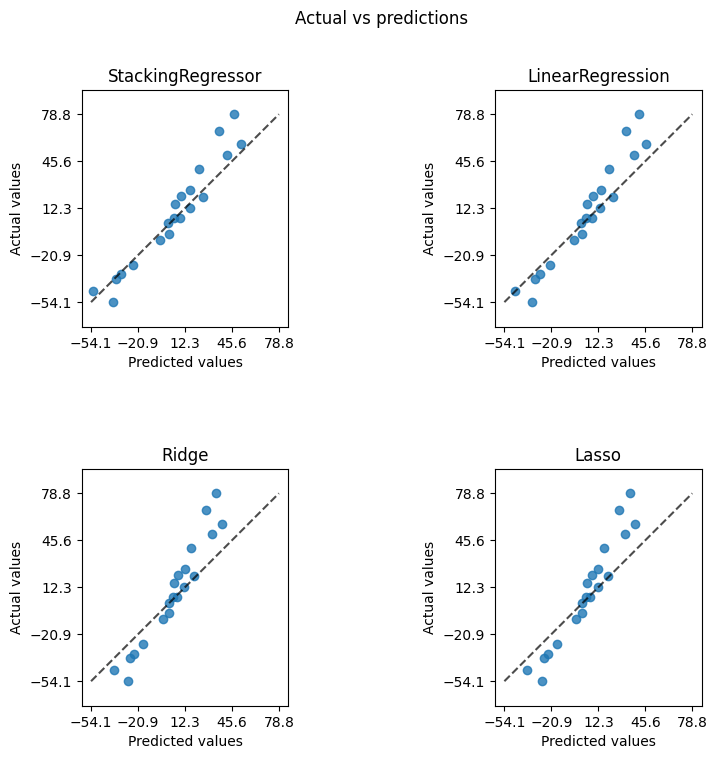

In [ ]:
# Predictions
st_reg_pred = st_reg.predict(X_test)
ln_pred = st_reg.named_estimators_['ln'].predict(X_test)
rid_pred = st_reg.named_estimators_['ridge'].predict(X_test)
las_pred = st_reg.named_estimators_['lasso'].predict(X_test)

# Display of prediction vs actual errors
fig2, ax2 = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
fig2.suptitle("Actual vs predictions")
st_reg_disp = PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=st_reg_pred,
    kind="actual_vs_predicted",
    random_state=RND_NUM,
    ax=ax2[0, 0])
ax2[0, 0].set_title("StackingRegressor")

ln_disp = PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=ln_pred,
    kind="actual_vs_predicted",
    random_state=RND_NUM,
    ax=ax2[0, 1])
ax2[0, 1].set_title("LinearRegression")

rid_disp = PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=rid_pred,
    kind="actual_vs_predicted",
    random_state=RND_NUM,
    ax=ax2[1, 0])
ax2[1, 0].set_title("Ridge")

las_disp = PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=rid_pred,
       kind="actual_vs_predicted",
    random_state=RND_NUM,
    ax=ax2[1, 1])
ax2[1, 1].set_title("Lasso")

fig2.subplots_adjust(hspace=0.6, wspace=1)

For the Ridge and Lasso, the prediction error is high. The predictions deviate more from the actual points. This is partly due to the strigent condition that we set the base models. The `max_iter=3` and `alpha=20` is severe enough to constraint the performance of these two base models.

It is interesting to note that the simple LinearRegression has a high prediction power in this straightforward linear regression problem. The StackingRegressor closely follows the LinearRegression.

At a closer examination, the StackingRegressor tracks the points more closely than the LinearRegressor.

Together with the coefficients of determinants above, we can see that StackingRegressor can make good use of the predictions from the base models to produce a better final predictions.

## Interesting facts about stacking and voting ensemble

For hard voting, tie in vote counting is often a problem. For sklearn, it resolves a tie by choosing the class labels according to the ascending sort order of the labels. For example, for class 0, 1, 2, 3, when there is a tie for the count of these four classes, class 0 will be chosen as the *winner* because 0 is at the beginning of the sort order. Perhaps this implementation is a little casual. Perhaps, the next criteria to determine a winner can be activated in case of a tie. For future implementation, perhaps hard voting can take into account the average of probability. When there is a tie, hard voting can activate the second layer criteria like average of probability to get the final predictions.

In stacking methods, the final estimator can also be made up of a few different estimators. That is, the predictions from each of the base models will be fed to a group of various final estimators. But, how are the predictions from the various final estimators are being processed into one final output? The sklearn API and User Guide do not have clear documentation on this aspect. As a guess, for regression problems, it is likely that an average of the various final outputs is taken as the final-final prediction. And for classificaion problem, it could be hard voting among the various final outputs.



## References

Hands-on machine learning with Scikit-Learn and TensorFlow concepts, tools, and techniques to build intelligent systems (2nd ed.). O’Reilly Media, Inc.

sklearn. (2012). 1.11. Ensemble methods — scikit-learn 0.22.1 documentation. Scikit-Learn.org. https://scikit-learn.org/stable/modules/ensemble.html

---

# Practical Question

Select a suitable toy dataset provided by Scikit-Learn.

Apply the Voting and Stacking methods.

Compare the performance between the Voting and Stacking ensembles, as well as the performance of the ensembles and their respective base estimators.

You should use four to five machine learning models that you would have learned in the course,
- such as linear regression, logistic regression, K-nearest neighbours, Naïve Bayes, decision trees/random forests and SVM, as **base estimators**,
- and logistic regression, linear regression or gradient boosted trees as the **meta learner** (for stacking).

# Dataset used

The breast cancer dataset is selected for the purpose of this assignment. This is a binary classification of 'malignant' or 'benign' outcomes.

In [ ]:
# Using iris dataset

# Import libraries

import numpy as np

from sklearn.datasets import load_breast_cancer

from sklearn.pipeline import Pipeline

print("Libraries imported.")

Libraries imported.


The breast cancer dataset is a classic and very easy binary classification dataset.

The following summary is obtained from sklearn docs:

|Classes | 2|
|---|---|
|Samples per class|212(M),357(B) |
|Samples total | 569 |
|Dimensionality | 30 |
|Features | real, positive |

In [ ]:
# Loading breast cancer dataset

bc = load_breast_cancer()

In [ ]:
# What are the target names?
# What does the data look like?

print(f"Target names: {bc.target_names}")
print(f"Last five rows of target: {bc.target[-5:]}")

Target names: ['malignant' 'benign']
Last five rows of target: [0 0 0 0 1]


In [ ]:
# Shape of the features and target

print(f"Shape of features: {bc.data.shape}")
print(f"Shape of target: {bc.target.shape}")

Shape of features: (569, 30)
Shape of target: (569,)


Setting the random number so that the output will random state will be always the same.

In [ ]:
# Set the random state to 0

RND_NUM = 0

rng = np.random.RandomState(seed=0)


# Choosing base models for ensembles

sklearn.linear_model.LinearRegression is taught in class. But it will not be used for the classification because it is a numerical regression algorithm. Hence, it is not suitable to be used for classes (or labels) classification.

Classification algorigthms that are suitable are listed as follows:
- LogisticRegression
- GaussianNB
- KNeighborsClassifier
- DecisionTreeClassifier
- RandomForestClassifier
- SVC

Ensembles to be used are listed as follows:
- StackingClassfier
- VotingClassifier

Among the base algorithms, all except SVC, implements the `predict_proba()`. So, for soft voting, all base algorithms are included except SVC. This is because soft voting needs predict_proba() to provide probabilities that can be averaged into a result.

For hard voting and stacking ensemble, all base algorithms (including SVC) are used.

In [ ]:
# Instantiate a base Logistic Regression classifier

# Logistic Regression as the base estimator

# LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0,
# fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None,
# solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False,
# n_jobs=None, l1_ratio=None)
# Implement predict_proba, so it can be used for soft voting.

# For small datasets, ‘liblinear’ is a good choice.
# multi_class='ovr' for binary classes

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe_log = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ('log_reg', LogisticRegression(
            solver='liblinear',
            multi_class='ovr',
            random_state=RND_NUM) )
    ]
)


In [ ]:
# Instantiate a Naive Bayes classefier

# GaussianNB(*, priors=None, var_smoothing=1e-09)
# Implement predict_proba(), can be used for soft voting

from sklearn.naive_bayes import GaussianNB

pipe_nb = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ('nb', GaussianNB())
    ]
)

In [ ]:
# Instantiate a kNN neighbors

# KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto',
# leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
# Implement predict_proba(), can be used for soft voting

# kNN calculates distances between neighbors, so it is good to
# scale the data.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

pipe_knn = Pipeline(
    [   ('min_max', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]
)

In [ ]:
# Instantiate a decision tree

# DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None,
# min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
# max_features=None, random_state=None, max_leaf_nodes=None,
# min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
# Implement predict_proba(), can be used for soft voting

# Scaling is not necessary for decision tree

from sklearn.tree import DecisionTreeClassifier

one_tree = Pipeline(
    [
        ('one_tree', DecisionTreeClassifier(random_state=RND_NUM))
    ]
)

In [ ]:
# Instantiate a random forest decision tree classifier

# RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None,
# min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
# max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
# bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0,
# warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
# Implement predict_proba(), can be used for soft voting

from sklearn.ensemble import RandomForestClassifier

forest = Pipeline(
    [
        ('rnd_frt', RandomForestClassifier(random_state=RND_NUM))
    ]
)

In [ ]:
# Instantiate a svm classifier
# SVM is sensitive to outliers, so robust scaling is necessary.

# SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0,
# shrinking=True, probability=False, tol=0.001, cache_size=200,
# class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr',
# break_ties=False, random_state=None)
# No predict_proba(), so only hard voting

from sklearn.svm import SVC

pipe_svc = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ('svm_clf', SVC(random_state=RND_NUM))
    ]
)


In [ ]:
# Put the base estimators together

# Estimator with names to be fed into the stacking
# ensemble.
# Note that SVC
base_all = [
    ('log', pipe_log),
    ('knn', pipe_knn),
    ('nb', pipe_nb),
    ('tree', one_tree),
    ('forest', forest),
    ('svc', pipe_svc)
]

# These are estimators with the predict_proba
# implemented. These are used by voting classifier.
base_proba = [
    ('log', pipe_log),
    ('knn', pipe_knn),
    ('nb', pipe_nb),
    ('tree', one_tree),
    ('forest', forest)
]

# Confirm the estimators used
for item in base_all:
    print(f"{item[0]}, {item[1]}")


log, Pipeline(steps=[('std_scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(multi_class='ovr', random_state=0,
                                    solver='liblinear'))])
knn, Pipeline(steps=[('min_max', MinMaxScaler()), ('knn', KNeighborsClassifier())])
nb, Pipeline(steps=[('std_scaler', StandardScaler()), ('nb', GaussianNB())])
tree, Pipeline(steps=[('one_tree', DecisionTreeClassifier(random_state=0))])
forest, Pipeline(steps=[('rnd_frt', RandomForestClassifier(random_state=0))])
svc, Pipeline(steps=[('std_scaler', StandardScaler()),
                ('svm_clf', SVC(random_state=0))])


In [ ]:
# Get estimators only, without the names

# Estimators without the names. This is for easy
# access to the estimator for fitting and getting
# performance metrics.

def get_estimator(estimator_list):
    estimator = [e[1] for e in estimator_list]
    return estimator

# Get the name of the estimators only.
def get_estimator_name(estimator_list):
    name = [e[0] for e in estimator_list]
    return name

# Choosing ensemble models

In [ ]:
# Logistic Regression as the final estimator for stacking estimator

# LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0,
# fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None,
# solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False,
# n_jobs=None, l1_ratio=None)

# For small datasets, ‘liblinear’ is a good choice.
# multi_class='ovr' for binary classes

final_log_reg = LogisticRegression(
    solver='liblinear',
    multi_class='ovr',
    random_state=RND_NUM
)

In [ ]:
# Stacking classifier

# StackingClassifier(estimators, final_estimator=None, *, cv=None,
# stack_method='auto', n_jobs=None, passthrough=False, verbose=0)

# Default final estimator is LogisticRegression

from sklearn.ensemble import StackingClassifier

stack_clf = StackingClassifier(
    estimators=base_all,
    final_estimator=final_log_reg,
)


In [ ]:
# VotingClassifier(estimators, *, voting='hard', weights=None, n_jobs=None,
# flatten_transform=True, verbose=False)

# All the base estimators, except SVC, implement predict_proba.
# So we will set the voting classifiers to the base estimators without the SVC.

from sklearn.ensemble import VotingClassifier

# Voting 'hard' majority votes are taken as the answer.
vote_hard = VotingClassifier(
    estimators=base_all,
    voting='hard'
)

# Voting 'soft' average of predict_proba of the base estimators
# are taken. Then, a classificatin is made.
# SVC is excluded because it does not have predict_proba().
vote_soft = VotingClassifier(
    estimators=base_proba,
    voting='soft'
)

In [ ]:
# Combine the ensembles into a list

ensemble_all = [
    ('stack_clf', stack_clf),
    ('vote_hard', vote_hard),
    ('vote_soft', vote_soft)
]

# Confirm the ensembles used
#for item in ensemble_all:
#    print(f"{item[0]}, {item[1]}")

# Fitting base models and ensembles

The steps are listed as follows:

- `StratifiedKFold` split the data into two sets of training and test data.
- The fold will contain approximately the same proportion of labels that are the same as the proportion of labels in the original dataset.
- One fold will be used for base estimators, and another fold for ensembles.
- For each of the base estimators and ensembles, performance metrics are compared.
- The metrics obtained from the training data using `cross_validate()` is used to determine the bias (training error).
- The prediction obtained from the test data is used to determine the variance (test error).
- Performance metrics used are precision, recall, and Matthew's correlation coefficient.  

In [ ]:
# A general method to fit any model

def fit_model(estimator, X_data, y_label):
    estimator.fit(X_data, y_label)

In [ ]:
# Split the data into training and test set

from sklearn.model_selection import train_test_split

# Start the split and training
def split_data():

    X_train, X_test, y_train, y_test = train_test_split(
        bc.data, bc.target,
        train_size=0.8,
        random_state=RND_NUM,
        shuffle=True,
        stratify=bc.target
    )

    # For debug purpose
    print(f"{X_train.shape=}")
    print(f"{y_train.shape=}")
    print(f"{X_test.shape=}")
    print(f"{y_test.shape=}")

    return X_train, X_test, y_train, y_test

# call the split_data
X_train, X_test, y_train, y_test = split_data()

X_train.shape=(455, 30)
y_train.shape=(455,)
X_test.shape=(114, 30)
y_test.shape=(114,)


# Performance metrics with MCC

MCC (Matthew's Correlation Coefficient) is used as the basis for evaluation of performances of the models.

For training error (bias) `cross_validate` is used with the training set to get scores for each `cv` fold. Here, three fold cv is used. Thus, we will get an array of three values for the MCC scores. Then, three values will be averaged using `np.mean`.

After we get the training scores, we get predict scores using the test set. We passed the X_test to `predict()` to get an array of prediction values. Then, with the prediction values, we call `matthew_corrcoef` to get the MCC score for prediction test.

Fit the model with training set

In [ ]:
# Get the bias (training error) from cross_validate()

# for the cv of the cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

# cross_validate(estimator, X, y=None, *, groups=None, scoring=None, cv=None,
# n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs',
# return_train_score=False, return_estimator=False, return_indices=False,
# error_score=nan)


def fit_cross_val(estimator_list, X_train_data, y_train_data):
    # Fit and cross validate

    # set the scoring metrics to return from the cross_validate
    scoring = ['matthews_corrcoef']

    # cv for cross_validate
    cv_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND_NUM)

    # for the score from cross_validate
    cv_score = dict()

    # Fit the estimator in the list to the train data
    for j, item in enumerate(estimator_list):
        # Extract the name and the estimator
        name = item[0]
        e = item[1]
        #print(j, name, e) # debug

        # Fit the estimator
        fit_model(e, X_train_data, y_train_data)

        cv_score[name] = cross_validate(
            estimator=e,
            X=X_train_data,
            y=y_train_data,
            cv=cv_fold,
            scoring=scoring
            )

    # return the cv_score
    return cv_score


In [ ]:
# For base and ensemble estimators

# Fit models.
# Get training error.
base_train_array = fit_cross_val(base_all,
                                 X_train, y_train)

ensemble_train_array = fit_cross_val(ensemble_all,
                                     X_train, y_train)


In [ ]:
# The score is returned as an array of 3 values
# because the cross_validate is set to 3 fold
# validations.
# We get the mean of the 3 scores

base_train_mean = dict()
ensemble_train_mean = dict()

for k, v in base_train_array.items():
    base_train_mean[k] = np.mean(v['test_matthews_corrcoef'])
    print(k, v['test_matthews_corrcoef'], base_train_mean[k])

for k, v in ensemble_train_array.items():
    ensemble_train_mean[k] = np.mean(v['test_matthews_corrcoef'])
    print(k, v['test_matthews_corrcoef'], ensemble_train_mean[k])

log [0.93016091 0.94459298 0.94323308] 0.9393289893291024
knn [0.91737896 0.93094934 0.94323308] 0.9305204600460364
nb [0.87495285 0.84795862 0.85808271] 0.8603313901558671
tree [0.8877193  0.85904493 0.83346547] 0.860076566159046
forest [0.90230474 0.84473679 0.9074094 ] 0.8848169764315222
svc [0.97192982 0.94384009 0.98585608] 0.9672086632823694
stack_clf [0.9860133  0.91607696 0.97161654] 0.9579022670555047
vote_hard [0.94384009 0.92992033 0.94402102] 0.9392604822841263
vote_soft [0.92992033 0.90152582 0.90111078] 0.9108523116415012


Prediction on test set

In [ ]:
# Now, call the predict of the estimators
# The prediction score is matthews_corrcoef

def predict_evaluate(estimator_list, X_test_data, y_test_data):

    # score is return as a key of name and value of score
    pred_score = dict()

    for j, item in enumerate(estimator_list):
        # Extract the name and the estimator
        name = item[0]
        e = item[1]
        #print(j, name, e)

        # Predict using the X_test
        y_pred = e.predict(X_test_data)

        # Get the score by comparing y_test and y_pred
        pred_score[name] = matthews_corrcoef(y_true=y_test_data,
                                    y_pred=y_pred)

    return pred_score

In [ ]:
# For base and ensemble estimators
# Get prediction data using the test folds
# that were obtained earlier.
# Evaluation metrics

# Both of the test data have not been seen by
# the estimators.

base_test_score = predict_evaluate(base_all,
                                   X_test, y_test)

ensemble_test_score = predict_evaluate(ensemble_all,
                                       X_test, y_test)

In [ ]:
# Check the size of the test data
print(X_test.shape)
print(y_test.shape)

(114, 30)
(114,)


In [ ]:
# Check the test score for base and ensemble

for k, v in base_test_score.items():
    print(k, v)

for k, v in ensemble_test_score.items():
    print(k, v)

log 0.962621902223779
knn 0.9058238738943076
nb 0.796936951050134
tree 0.8713438408287706
forest 0.8886350389948482
svc 0.9246031746031746
stack_clf 0.9433397594898876
vote_hard 0.8886350389948482
vote_soft 0.8869047619047619


# Discussion of performance

In [ ]:
# To get the matthews correlation coefficient into
# a list. Then, the list will be used to plot a bar
# chart. From the bar chart, we can compare the training
# and test error of the base and ensembles.

base_train_list = []
ensemble_train_list = []

base_test_list = []
ensemble_test_list = []


# Get the base estimators training and test score
for name in get_estimator_name(base_all):
    # Get the train score (from cross_validate)
    base_train_list.append(base_train_mean[name])

    # Get the test score
    base_test_list.append(base_test_score[name])

# Get the ensemble estimators training and test score
for name in get_estimator_name(ensemble_all):
    # Get the training score (from cross_validate)
    ensemble_train_list.append(ensemble_train_mean[name])

    # Get the test score
    ensemble_test_list.append(ensemble_test_score[name])

In [ ]:
# Plot bar chart to show the various scores of
# each of the estimators.
# It is clearer to see the scores individually.

import matplotlib.pyplot as plt

def plot_score_chart(score_name, score_list, label_name):
    fig, ax = plt.subplots(figsize=(10, 4))
    bar_container = ax.bar(label_name, score_list);
    ax.set_title(score_name);
    ax.bar_label(bar_container, fmt='{:,.4f}');

## Base models against Ensembles

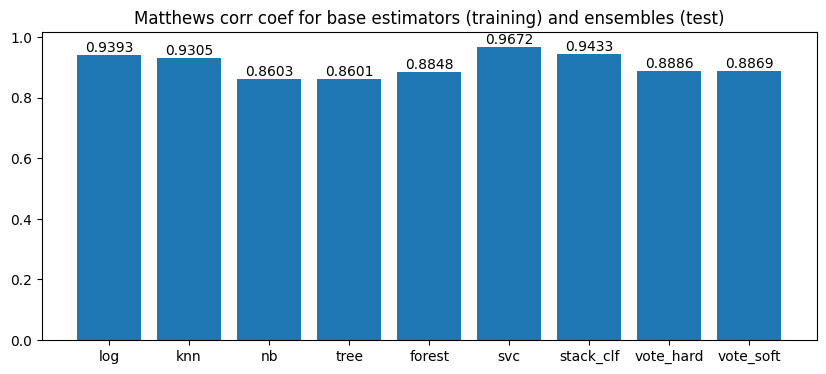

In [ ]:
# Chart the bar of each of the score for easy visualization.

# Compare the base estimators training errors and
# the ensemble test erros.

plot_score_chart(score_name='Matthews corr coef for base estimators '
                '(training) and ensembles (test)',
                 score_list=(base_train_list+ensemble_test_list),
                 label_name=get_estimator_name(base_all+ensemble_all))

Conclusion:

In this evaluation, MCC is used. According to scikit-learn API `sklearn.metrics.matthews_corrcoef`, MCC is in essence a correlation coefficient value between -1 and +1.
- A coefficient of +1 represents a perfect prediction,
- 0 an average random prediction and
- -1 an inverse prediction.

In the bar chart above, except for SVC, the training error is shown by the overall lower MCC scores from the base estimators (log, knn, nb, tree and forest). The ensembles (stack_clf, vote_hard and vote_soft) have higher MCC score than the base estimators.

This is one of the advantage of using ensembles of estimators. Individual base estimators are weak learners, but when they are ensembled into proper algorithms, each of them contribute to a higher prediction scores.



## Stacking against hard voting classifiers

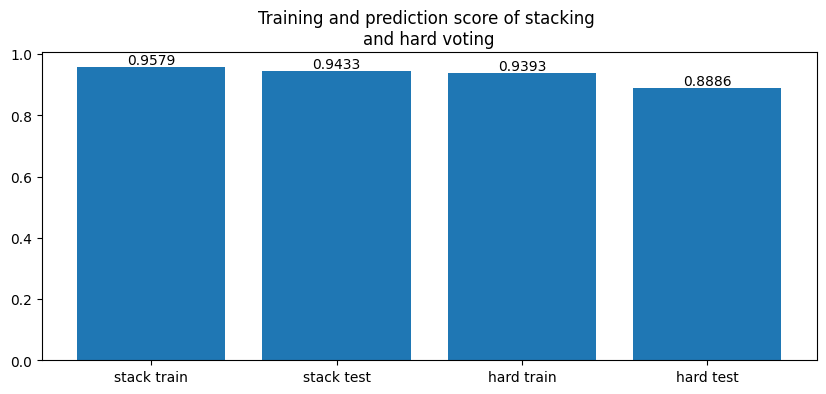

In [ ]:
# The training and prediction score of stacking and
# hard voting.

score_name = 'Training and prediction score of stacking \n'\
             'and hard voting'
label_name = [
    'stack train', 'stack test',
    'hard train', 'hard test'
]

score_list = [
    ensemble_train_mean['stack_clf'],
    ensemble_test_score['stack_clf'],
    ensemble_train_mean['vote_hard'],
    ensemble_test_score['vote_hard'],

]
plot_score_chart(score_name=score_name,
                 score_list=score_list,
                 label_name=label_name)


Stacking classifier performs better than the hard voting classifiers. In the bar chart below, we can see the training error (bias) and prediction error (variance) of these two classifiers.

Comparing the training error (bias) and prediction error (variance):
- The stacking is only slightly lower in MCC score for the prediction test, that is bias and variance are about the same.
- The hard voting test drops quite a lot for prediction test, that is bias is higher than variance.

## Hard against soft voting classifier

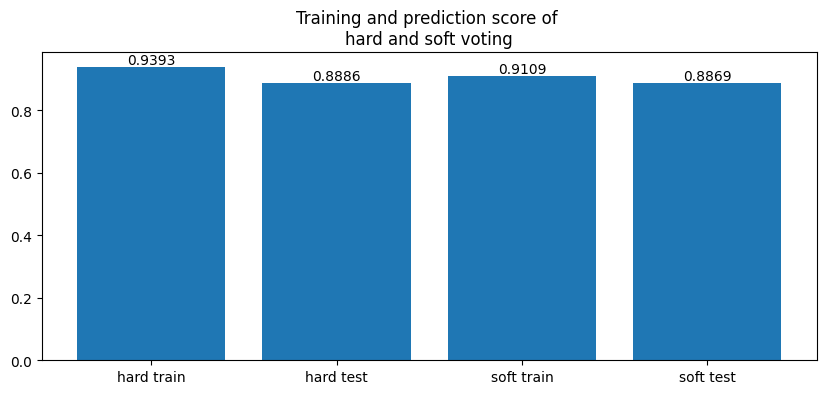

In [ ]:
# The training and prediction score of hard and
# soft voting.

score_name = 'Training and prediction score of \n'\
             'hard and soft voting'
label_name = [
    'hard train', 'hard test',
    'soft train', 'soft test'
]

score_list = [
    ensemble_train_mean['vote_hard'],
    ensemble_test_score['vote_hard'],
    ensemble_train_mean['vote_soft'],
    ensemble_test_score['vote_soft'],

]
plot_score_chart(score_name=score_name,
                 score_list=score_list,
                 label_name=label_name)


Now, we compare hard voting and soft voting. These two classifiers differ only in the use of SVM. Soft voting needs to use estimators that implement `predict_proba()`. However, SVM does not implement `predict_proba()`. So, soft voting cannot use SVM.

We compare the training and prediction error of these two classifiers.
- Hard voting has higher training error (bias) compared to soft voting.
- Therefore, the difference in training error (bias) and prediction error (variance) is larger in hard voting.
- The difference in bias and variance for soft voting is smaller.


## SVM training against prediction

Hard voting uses SVM. Therefore, the training error (bias) of hard voting is influenced by SVM. We can see from the chart below that SVM has good training score (low bias) but and poor prediction score (high variance).

This high bias effect of the SVM influences the hard voting classifier, causing the hard voting classifier to have lower training error (low bias) and higher prediction error (high variance).

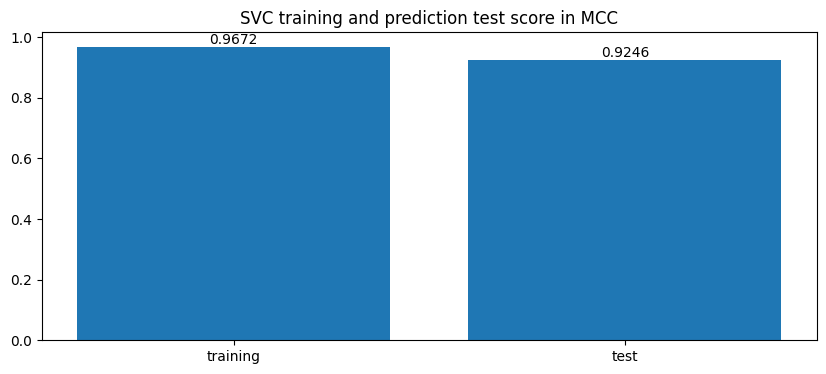

In [ ]:
# The training score and prediction test score
# of SVC.

plot_score_chart(score_name='SVC training and prediction test score in MCC',
                 score_list=[base_train_mean['svc'], base_test_score['svc']],
                 label_name=['training', 'test'])
